<a href="https://colab.research.google.com/github/pSN0W/AI_Practice/blob/main/T_SNE_on_Amazon_fine_food_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading Data from kaggle


In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pratyakshsingh","key":"e1a64879a9d9f50ccfaafd16798ab02d"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 98% 238M/242M [00:02<00:00, 73.1MB/s]
100% 242M/242M [00:02<00:00, 86.7MB/s]


In [6]:
from zipfile import ZipFile
file_name = "amazon-fine-food-reviews.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()

#Data Processing

##Data Selection

###Importing Module

In [175]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn import decomposition

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import tqdm.notebook as tq
import os

from bs4 import BeautifulSoup
from sklearn.manifold import TSNE

###Working on Data

In [9]:
df=pd.read_csv("Reviews.csv")

In [ ]:
df.columns

In [11]:
#Choosing 5k of only those points for which score is not equal to 3

intermediate_data=df[df['Score']!=3].head(5000)

In [12]:
intermediate_data.size

50000

In [17]:
intermediate_data['Score'].value_counts()

5    3420
4     767
1     504
2     309
Name: Score, dtype: int64

In [18]:
def partition(x):
  if x>3:
    return "positive"
  return "negative"

In [19]:
positiveNegative=intermediate_data['Score'].map(partition)

In [20]:
intermediate_data['Score']=positiveNegative

In [21]:
intermediate_data['Score'].value_counts()

positive    4187
negative     813
Name: Score, dtype: int64

###Data Cleansing

####Removing Duplicates

In [22]:
sorted_data=intermediate_data.sort_values(by='ProductId')

In [23]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',ignore_index=True)

In [24]:
final.size

49860

In [25]:
final['Score'].value_counts()

positive    4178
negative     808
Name: Score, dtype: int64

####Removing incorrect Data

In [26]:
final=final[final['HelpfulnessNumerator']<=final['HelpfulnessDenominator']]

In [27]:
final.size

49860

##Reading Data

In [28]:
final.iloc[20]

Id                                                                     1435
ProductId                                                        B0000VLH8S
UserId                                                       A1HPPPBBMZD78K
ProfileName                Judy J. Blaskowski "Coauthor of The Step Dyna...
HelpfulnessNumerator                                                      6
HelpfulnessDenominator                                                    6
Score                                                              positive
Time                                                             1175644800
Summary                                   Create Exquisite Cake Decorations
Text                      I used Super Gold Luster Dust to create the mo...
Name: 20, dtype: object

In [32]:
final['Text'].values[20]

'I used Super Gold Luster Dust to create the most exquisite chocolate aspen leaves for the groom\'s cake at my son\'s wedding. By using an artist\'s paintbrush to lightly coat the molded leaves with Luster Dust, the result was startlingly beautiful. In contrast to food coloring, the Luster Dust brushes on easily and imparts a realistically metallic color and sheen. The containers are small but the product goes a long way, making it extremely economical to use. <a href="http://www.amazon.com/gp/product/1933981350">The Step Dynamic: A Powerful Strategy for Successfully Growing Your Business</a>'

Here we see that text contains a lot of html tags special characters and href also and also short forms

In [33]:
final['Summary'].values[20]

'Create Exquisite Cake Decorations'

Summary contains a small synopsis of text and obviously text holds fore information then the summary so we will try to convert text to vector

#Text Preprcessing

In [35]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [36]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [37]:
preprocessed_text=[]

for sentance in tq.tqdm(final['Text'].values):
  sentance = re.sub("http\S+","",sentance)  #remove href
  sentance = BeautifulSoup(sentance,"lxml").get_text()  #remove tags from the sentance
  sentance = decontracted(sentance)   #expands the short forms in sentance
  sentance = re.sub("\S*\d\S*","",sentance).strip()   #removes words with number in it
  sentance = re.sub("[^A-Za-z]+"," ",sentance)  #removes special character
  sentance = ' '.join([word.lower() for word in sentance.split()  if word not in stopwords and len(word)>2])
  preprocessed_text.append(sentance)

In [38]:
preprocessed_text[50]

'and not mean asian sauces this easily best sauce ever put everything gotten hand way see else latest thing pouring peanuts coating peanuts sauce then eat nuts spoon keep hands clean sounds gross delicious'

In [40]:
print(len(final))
len(preprocessed_text)

4986


4986

#Featurisation

##BoW

In [41]:
count_vect = CountVectorizer(min_df=10)
Bow_amazon = count_vect.fit_transform(tq.tqdm(preprocessed_text))
print("Few of the words are : ",count_vect.get_feature_names()[:10])
print("Shape of the matrix is : ",Bow_amazon.get_shape())
print("Type of matrix is : ",type(Bow_amazon))


Few of the words are :  ['ability', 'able', 'about', 'absolute', 'absolutely', 'according', 'acid', 'acidic', 'acidity', 'across']
Shape of the matrix is :  (4986, 2268)
Type of matrix is :  <class 'scipy.sparse.csr.csr_matrix'>


## Trigram BoW

In [43]:
count_vect = CountVectorizer(min_df=10,ngram_range=(1,3))
Bow_tri_amazon = count_vect.fit_transform(tq.tqdm(preprocessed_text))
print("Few of the words are : ",count_vect.get_feature_names()[:10])
print("Shape of the matrix is : ",Bow_tri_amazon.get_shape())
print("Type of matrix is : ",type(Bow_tri_amazon))


Few of the words are :  ['ability', 'able', 'able find', 'able get', 'about', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'according']
Shape of the matrix is :  (4986, 3308)
Type of matrix is :  <class 'scipy.sparse.csr.csr_matrix'>


##Tfidf BoW

In [44]:
count_vect = TfidfVectorizer(ngram_range=(1,3),min_df=10)
Bow_tfidf_amazon = count_vect.fit_transform(tq.tqdm(preprocessed_text))
print("Few of the words are : ",count_vect.get_feature_names()[:10])
print("Shape of the matrix is : ",Bow_tfidf_amazon.get_shape())
print("Type of matrix is : ",type(Bow_tfidf_amazon))


Few of the words are :  ['ability', 'able', 'able find', 'able get', 'about', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'according']
Shape of the matrix is :  (4986, 3308)
Type of matrix is :  <class 'scipy.sparse.csr.csr_matrix'>


##Word2Vector

In [45]:
list_of_sentances=[]
for sentance in tq.tqdm(preprocessed_text):
  list_of_sentances.append(sentance.split())

In [ ]:
list_of_sentances[20]

In [47]:
# Making our own word2vec model
word_vec = Word2Vec(list_of_sentances,size=50,min_count=10,workers=4)

In [ ]:
word_vec.wv['good']

In [49]:
print(word_vec.most_similar("good"))
print("="*200)
print(word_vec.most_similar("bad"))

[('really', 0.9949197173118591), ('smooth', 0.9916654825210571), ('rich', 0.99144446849823), ('bitter', 0.9910399913787842), ('texture', 0.989192008972168), ('nice', 0.9886987209320068), ('spicy', 0.9886322021484375), ('cocoa', 0.9877500534057617), ('real', 0.9869430661201477), ('tasty', 0.9868767261505127)]
[('think', 0.9984448552131653), ('though', 0.9981406331062317), ('sure', 0.998020589351654), ('rather', 0.997931718826294), ('expecting', 0.9979159235954285), ('probably', 0.9977788329124451), ('wrong', 0.9976728558540344), ('you', 0.9976484179496765), ('might', 0.997542679309845), ('although', 0.9975239634513855)]


In [51]:
word_vec_words = word_vec.wv.vocab
len(word_vec_words)

2451

##Average Word2Vec

In [64]:
avg_w2v=[]

for sentance in tq.tqdm(list_of_sentances):
  temp_vect=np.zeros(50)
  cnt=0
  for word in sentance:
    if word in word_vec_words:
      vec=word_vec.wv[word]
      temp_vect+=vec
      cnt+=1
  if cnt:
    temp_vect/=cnt
    temp_vect = np.append(temp_vect,1)
  else:
    temp_vect = np.append(temp_vect,0)
  avg_w2v.append(temp_vect)

In [63]:
print(len(final))
print(len(avg_w2v))
print(len(avg_w2v[5]))

4986
4986
51


We appended one more column to the matrix which will tell if the cnt=0 or not when cnt is not 0 this means w2v produces no vector for that sentence so that datapoint must be removed.

We append vectors with no vector representation also cause we don't want to ruin the order of Score. For example if there is no vector representation for 7th sentance and we append nothing then when we will add score to our column it will mess up the order

##Tfidf W2V

In [65]:
# to find the idf of all the words

model = TfidfVectorizer()
model.fit(preprocessed_text)

feat_words = list(model.get_feature_names())
idf_values = list(model.idf_)

In [73]:
# Creating a dictionary to get the idf of words quickly

idf_dictionary={}

for i in range(len(feat_words)):
  idf_dictionary[feat_words[i]] = idf_values[i]

print(idf_dictionary['good'])

2.3231604755097433


In [76]:
def tf(phrase):
  dic={}
  for word in phrase:
    dic.setdefault(word,0)
    dic[word]+=1
  return dic

In [78]:
#Creating Tfidf vector

tfidf_w2v=[]

for sentance in tq.tqdm(list_of_sentances):
  temp_vect = np.zeros(50)
  total_weight = 0.0
  tf_dictionary = tf(sentance)
  for word in sentance:
    if word in word_vec_words and word in feat_words:
      vec = word_vec.wv[word]
      tfidf = idf_dictionary[word]*tf_dictionary[word]
      temp_vect+=vec*tfidf
      total_weight+=tfidf
  if total_weight:
    temp_vect/=total_weight
    temp_vect=np.append(temp_vect,1)
  else:
    temp_vect=np.append(temp_vect,0)
  tfidf_w2v.append(temp_vect)

In [80]:
print(len(final))
print(len(tfidf_w2v))
print(len(tfidf_w2v[5]))

4986
4986
51


#Plotting

In [87]:
label_i=np.array(final['Score'])
label_i.shape

(4986,)

In [90]:
label = label_i.reshape(-1,1)
label.shape

array(['positive', 'positive', 'positive', ..., 'positive', 'positive',
       'negative'], dtype=object)

##PCA

###PCA on BoW

In [103]:
Bow_amazon.get_shape()

(4986, 2268)

In [104]:
#converting to array
Bow_amazon_arr = np.array(Bow_amazon.toarray())
Bow_amazon_arr.shape

(4986, 2268)

In [108]:
#
pca = decomposition.PCA()
pca.n_components=2
Bow_2D = pca.fit_transform(Bow_amazon_arr)

In [109]:
Bow_2D.shape

(4986, 2)

In [112]:
# creating a dataframe to plot 

Bow_final = np.concatenate((Bow_2D,label),axis=1)
Bow_final_df = pd.DataFrame(data=Bow_final,columns=("1st pricipal dimension","2nd pricipal dimension","label"))
Bow_final_df.head(3)

,1st pricipal dimension,2nd pricipal dimension,label
0,-1.34089,-0.027546,positive
1,-0.84388,-0.154246,positive
2,-0.777378,-0.050582,positive


Text(0.5, 1.0, 'PCA plot for Normal Bag of Word')

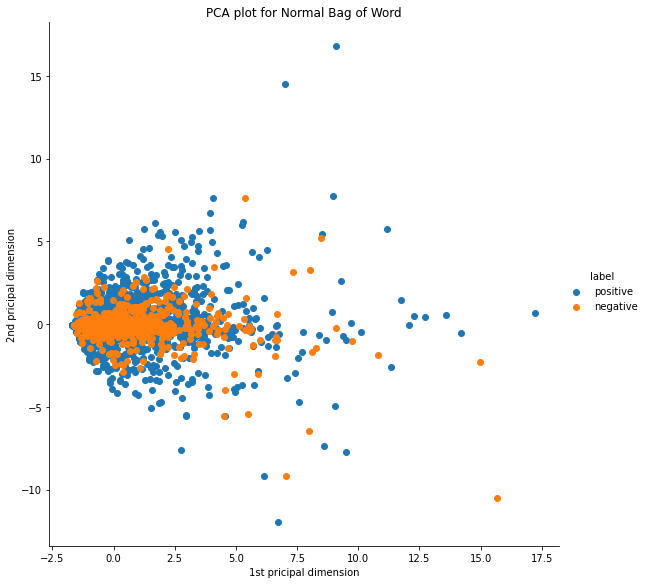

In [113]:
# Plotting

sns.FacetGrid(Bow_final_df,hue="label",size=8).map(plt.scatter,"1st pricipal dimension","2nd pricipal dimension").add_legend()
plt.title("PCA plot for Normal Bag of Word")

###PCA on trigram BoW

In [114]:
Bow_tri_amazon.get_shape()

(4986, 3308)

In [115]:
#converting to array
Bow_tri_amazon_arr = np.array(Bow_tri_amazon.toarray())
Bow_tri_amazon_arr.shape

(4986, 3308)

In [117]:
#Defining the model
pca = decomposition.PCA()
pca.n_components=2
Bow_tri_2D = pca.fit_transform(Bow_tri_amazon_arr)

In [118]:
Bow_tri_2D.shape

(4986, 2)

In [120]:
# creating a dataframe to plot 

Bow_tri_final = np.concatenate((Bow_tri_2D,label),axis=1)
Bow_tri_final_df = pd.DataFrame(data=Bow_tri_final,columns=("1st pricipal dimension","2nd pricipal dimension","label"))
Bow_tri_final_df.head(3)

,1st pricipal dimension,2nd pricipal dimension,label
0,-1.35114,-0.0165322,positive
1,-0.854357,-0.138364,positive
2,-0.790164,-0.0208181,positive


Text(0.5, 1.0, 'PCA plot for Trigram Bag of Word')

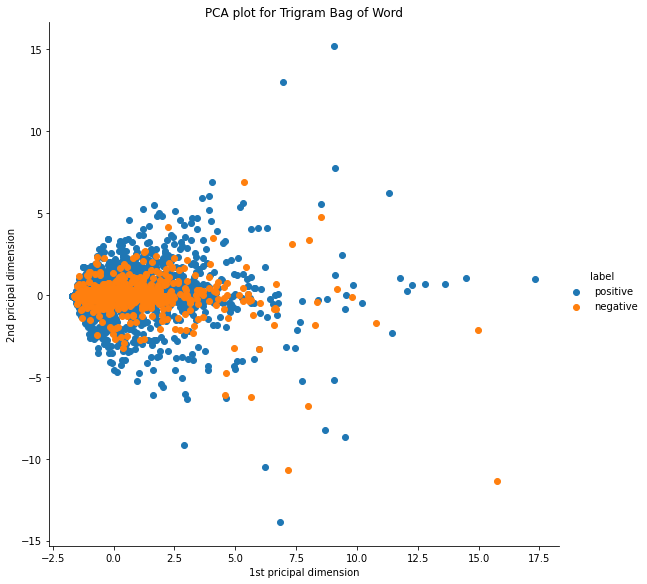

In [121]:
# Plotting

sns.FacetGrid(Bow_tri_final_df,hue="label",size=8).map(plt.scatter,"1st pricipal dimension","2nd pricipal dimension").add_legend()
plt.title("PCA plot for Trigram Bag of Word")

###PCA on tfidf BoW

In [122]:
Bow_tfidf_amazon.get_shape()

(4986, 3308)

In [123]:
#converting to array
Bow_tfidf_amazon_arr = np.array(Bow_tfidf_amazon.toarray())
Bow_tfidf_amazon_arr.shape

(4986, 3308)

In [124]:
#Defining the model
pca = decomposition.PCA()
pca.n_components=2
Bow_tfidf_2D = pca.fit_transform(Bow_tfidf_amazon_arr)

In [125]:
Bow_tfidf_2D.shape

(4986, 2)

In [126]:
# creating a dataframe to plot 

Bow_tfidf_final = np.concatenate((Bow_tfidf_2D,label),axis=1)
Bow_tfidf_final_df = pd.DataFrame(data=Bow_tfidf_final,columns=("1st pricipal dimension","2nd pricipal dimension","label"))
Bow_tfidf_final_df.head(3)

,1st pricipal dimension,2nd pricipal dimension,label
0,-0.0102068,-0.0153633,positive
1,-0.0206221,-0.0302877,positive
2,-0.022977,-0.0188074,positive


Text(0.5, 1.0, 'PCA plot for Tfidf Bag of Word')

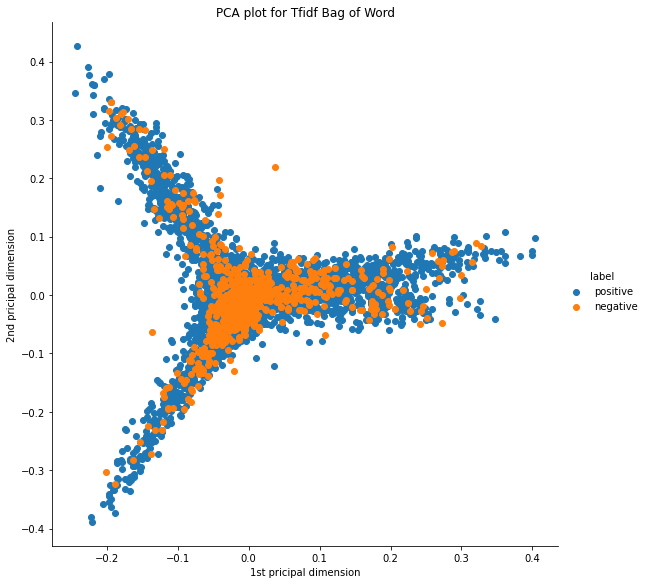

In [127]:
# Plotting

sns.FacetGrid(Bow_tfidf_final_df,hue="label",size=8).map(plt.scatter,"1st pricipal dimension","2nd pricipal dimension").add_legend()
plt.title("PCA plot for Tfidf Bag of Word")

###PCA on avg Word2Vec

In [158]:
#Here we try to find label of those index for which we have a vector
temp_df=pd.DataFrame(data=avg_w2v)
temp_df['label']=label
print(temp_df[50].value_counts())
print("="*200)
temp_df=temp_df[temp_df[50]==1]
print(temp_df[50].value_counts())

1.0    4971
0.0      15
Name: 50, dtype: int64
1.0    4971
Name: 50, dtype: int64


In [159]:
#Saving the label in an array
label_avg=np.array(temp_df['label'])
print(len(label_avg))
label_avg=label_avg.reshape(-1,1)
label_avg.shape

4971


(4971, 1)

In [160]:
#Dropping the columns label and 50 so that we are left with 50dim vector
temp_df = temp_df.drop(['label',50],axis=1)
temp_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.380888,0.142182,0.292685,-0.055969,-0.056525,-0.172485,-0.381913,-0.217159,0.203084,0.844957,0.273949,0.250933,0.361802,-0.364565,-0.495533,0.348248,0.024088,-0.015568,0.186452,-0.208661,0.140756,0.064639,0.109741,0.529166,0.710849,-0.257645,-0.575087,0.002113,0.167078,0.110791,0.059368,0.031152,-0.033989,0.081841,0.314492,0.383163,-0.070213,0.06198,-0.181601,-0.134949,-0.174222,0.465125,0.151482,-0.112454,0.38775,0.292414,0.086167,0.451379,0.220494,-0.28272


In [161]:
temp_df.shape

(4971, 50)

In [162]:
#Saving the values in a nd array to perform pca

avg_w2v_vectors = np.array(temp_df)
avg_w2v_vectors.shape

(4971, 50)

In [163]:
#Defining Model
pca=decomposition.PCA()
pca.n_components=2
avg_w2v_2D = pca.fit_transform(avg_w2v_vectors)
avg_w2v_2D.shape

(4971, 2)

In [164]:
#Appending label and creating a dataframe
avg_w2v_int = np.concatenate((avg_w2v_2D,label_avg),axis=1)
print(avg_w2v_int.shape)
avg_w2v_2D_df = pd.DataFrame(data=avg_w2v_int,columns=("1st pricipal dimension","2nd pricipal dimension","label"))
avg_w2v_2D_df.head(1)

(4971, 3)


,1st pricipal dimension,2nd pricipal dimension,label
0,0.121037,0.123095,positive


Text(0.5, 1.0, 'Average Word2Vec plotted by PCA')

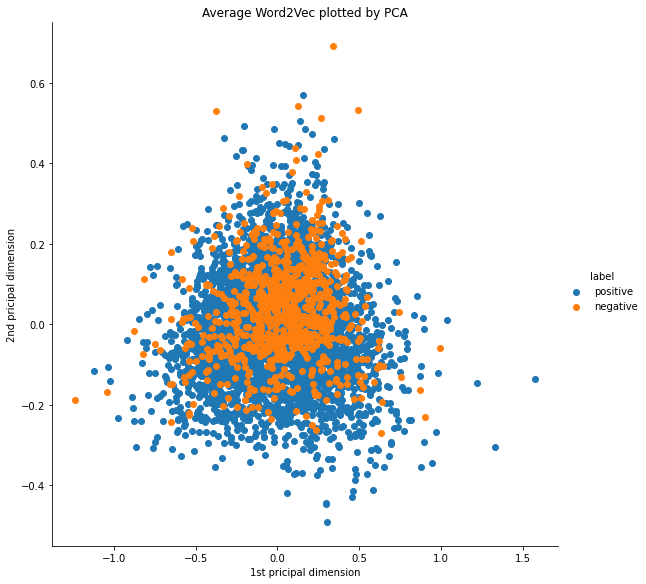

In [165]:
#Plotting

sns.FacetGrid(avg_w2v_2D_df,hue="label",size=8).map(plt.scatter,"1st pricipal dimension","2nd pricipal dimension").add_legend()
plt.title("Average Word2Vec plotted by PCA")

###PCA on Tfidf Word2Vec

In [167]:
#Here we try to find label of those index for which we have a vector
temp_df=pd.DataFrame(data=tfidf_w2v)
temp_df['label']=label
print(temp_df[50].value_counts())
print("="*200)
temp_df=temp_df[temp_df[50]==1]
print(temp_df[50].value_counts())

1.0    4971
0.0      15
Name: 50, dtype: int64
1.0    4971
Name: 50, dtype: int64


In [168]:
#Saving the label in an array
label_tfidf=np.array(temp_df['label'])
print(len(label_tfidf))
label_tfidf=label_tfidf.reshape(-1,1)
label_tfidf.shape

4971


(4971, 1)

In [169]:
#Dropping the columns label and 50 so that we are left with 50dim vector
temp_df = temp_df.drop(['label',50],axis=1)
temp_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.351655,0.136623,0.264805,-0.041852,-0.05634,-0.155504,-0.359614,-0.20535,0.189979,0.783107,0.252979,0.22532,0.334676,-0.332618,-0.457375,0.323871,0.015551,-0.01673,0.171509,-0.185991,0.132189,0.054848,0.10067,0.494354,0.667762,-0.230916,-0.53073,0.001316,0.160927,0.111569,0.058157,0.017707,-0.028168,0.081952,0.291389,0.3517,-0.062431,0.053967,-0.16332,-0.129668,-0.166798,0.428141,0.140115,-0.110254,0.359011,0.273848,0.077501,0.422952,0.204782,-0.259401


In [170]:
temp_df.shape

(4971, 50)

In [171]:
#Saving the values in a nd array to perform pca

tfidf_w2v_vectors = np.array(temp_df)
tfidf_w2v_vectors.shape

(4971, 50)

In [172]:
#Defining Model
pca=decomposition.PCA()
pca.n_components=2
tfidf_w2v_2D = pca.fit_transform(tfidf_w2v_vectors)
tfidf_w2v_2D.shape

(4971, 2)

In [176]:
#Appending label and creating a dataframe
tfidf_w2v_int = np.concatenate((tfidf_w2v_2D,label_tfidf),axis=1)
print(tfidf_w2v_int.shape)
tfidf_w2v_2D_df = pd.DataFrame(data=tfidf_w2v_int,columns=("1st pricipal dimension","2nd pricipal dimension","label"))
tfidf_w2v_2D_df.head(1)

(4971, 3)


,1st pricipal dimension,2nd pricipal dimension,label
0,0.15658,0.195921,positive


Text(0.5, 1.0, 'Tfidf Word2Vec plotted by PCA')

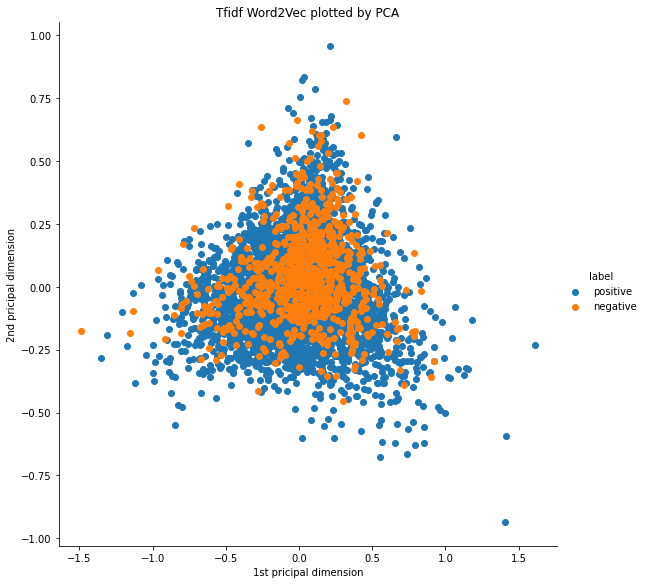

In [177]:
#Plotting

sns.FacetGrid(tfidf_w2v_2D_df,hue="label",size=8).map(plt.scatter,"1st pricipal dimension","2nd pricipal dimension").add_legend()
plt.title("Tfidf Word2Vec plotted by PCA")

##T-SNE

###BoW

Text(0.5, 1.0, 'Normal Bag of Word with T-SNE')

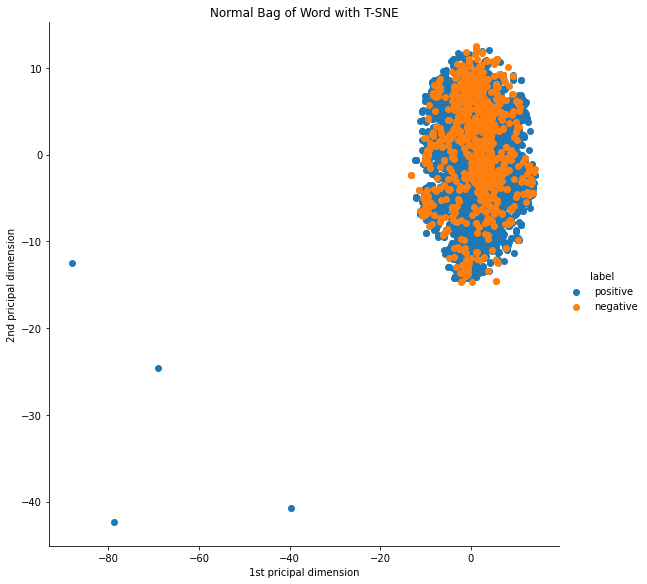

In [184]:
model = TSNE(n_components=2,n_iter=10000,perplexity=30)
tsne_bow = model.fit_transform(Bow_amazon_arr)

tsne_bow_final = np.concatenate((tsne_bow,label),axis=1)
tsne_bow_df = pd.DataFrame(data=tsne_bow_final,columns=("1st pricipal dimension","2nd pricipal dimension","label"))

sns.FacetGrid(tsne_bow_df,hue="label",size=8).map(plt.scatter,"1st pricipal dimension","2nd pricipal dimension").add_legend()
plt.title("Normal Bag of Word with T-SNE")

###Trigram Bag of Word

Text(0.5, 1.0, 'Trigram Bag of Word with T-SNE')

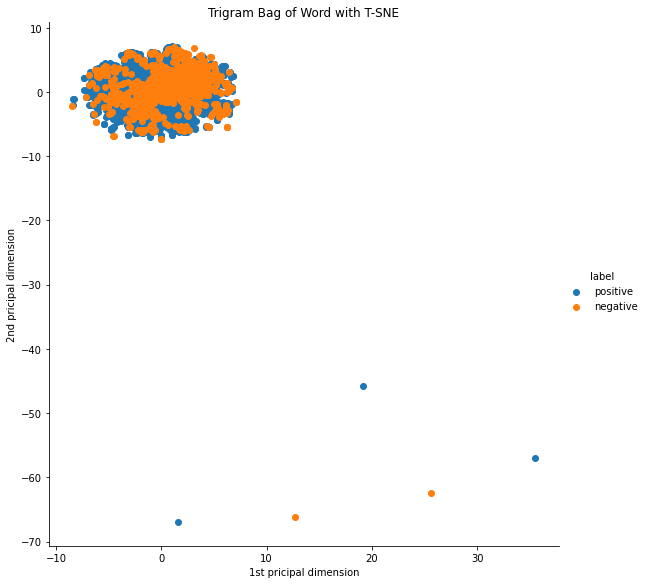

In [185]:
model = TSNE(n_components=2,n_iter=10000,perplexity=50)
tsne_bow_tri = model.fit_transform(Bow_tri_amazon_arr)

tsne_bow_tri_final = np.concatenate((tsne_bow_tri,label),axis=1)
tsne_bow_tri_df = pd.DataFrame(data=tsne_bow_tri_final,columns=("1st pricipal dimension","2nd pricipal dimension","label"))

sns.FacetGrid(tsne_bow_tri_df,hue="label",size=8).map(plt.scatter,"1st pricipal dimension","2nd pricipal dimension").add_legend()
plt.title("Trigram Bag of Word with T-SNE")

###Tfidf Bag of Word

Text(0.5, 1.0, 'Tfidf Bag of Word with T-SNE')

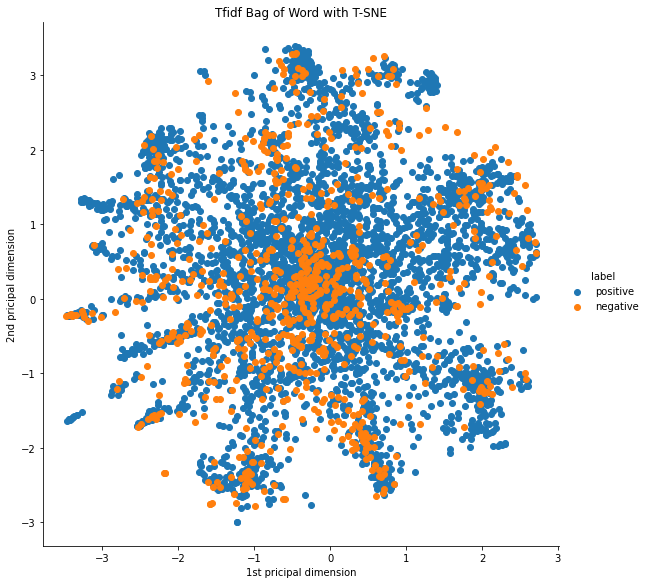

In [186]:
model = TSNE(n_components=2,n_iter=10000,perplexity=50)
tsne_bow_tfidf = model.fit_transform(Bow_tfidf_amazon_arr)

tsne_bow_tfidf_final = np.concatenate((tsne_bow_tfidf,label),axis=1)
tsne_bow_tfidf_df = pd.DataFrame(data=tsne_bow_tfidf_final,columns=("1st pricipal dimension","2nd pricipal dimension","label"))

sns.FacetGrid(tsne_bow_tfidf_df,hue="label",size=8).map(plt.scatter,"1st pricipal dimension","2nd pricipal dimension").add_legend()
plt.title("Tfidf Bag of Word with T-SNE")

###Average Word2Vec

In [ ]:
model = TSNE(n_components=2,n_iter=10000,perplexity=50)
tsne_avg_w2v = model.fit_transform(avg_w2v_vectors)

tsne_avg_w2v_final = np.concatenate((tsne_avg_w2v,label_avg),axis=1)
tsne_avg_w2v_df = pd.DataFrame(data=tsne_avg_w2v_final,columns=("1st pricipal dimension","2nd pricipal dimension","label"))

sns.FacetGrid(tsne_avg_w2v_df,hue="label",size=8).map(plt.scatter,"1st pricipal dimension","2nd pricipal dimension").add_legend()
plt.title("Average W2V with T-SNE")

###Tfidf Bag of Word

In [ ]:
model = TSNE(n_components=2,n_iter=10000,perplexity=50)
tsne_tfidf_w2v = model.fit_transform(tfidf_w2v_vectors)

tsne_tfidf_w2v_final = np.concatenate((tsne_tfidf_w2v,label_tfidf),axis=1)
tsne_tfidf_w2v_df = pd.DataFrame(data=tsne_tfidf_w2v_final,columns=("1st pricipal dimension","2nd pricipal dimension","label"))

sns.FacetGrid(tsne_tfidf_w2v_df,hue="label",size=8).map(plt.scatter,"1st pricipal dimension","2nd pricipal dimension").add_legend()
plt.title("Tfidf W2V. with T-SNE")